## Install packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import os
#import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition


In [2]:
!pip install torchviz
import torchviz

     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=4f83f3215b5928483bc6319c8c2a5fe64bf2095db3ad09a67fc4e06dffab5731
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [3]:
os.mkdir('/content/PythonCode')
os.chdir('/content/PythonCode/')
!git clone https://github.com/CIA-Oceanix/DinAE_4DVarNN_torch.git

Cloning into 'DinAE_4DVarNN_torch'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 83 (delta 30), reused 38 (delta 9), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [0]:
os.chdir('/content/PythonCode/DinAE_4DVarNN_torch')
import torch_4DVarNN_dinAE as NN_4DVar

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ResearchData/patchDataset_OcciputData.nc
import os
os.chdir('/content/drive/My Drive/')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
'/content/drive/My Drive/ResearchData/patchDataset_OcciputData.nc'
/content/drive/My Drive


# Load and prepare data (MNIST/image data)

In [5]:
flagRandomSeed = 0
if flagRandomSeed == 0:
  print('........ Random seed set to 100')
  np.random.seed(100)
  torch.manual_seed(100)
Nsquare  = int(3)
Wsquare  = int(4)
sigNoise = 0.1#0.25#
flagMNISTDataType = 0 # 0: rawa mnist data, 1: mnist data projected onto first 50 components, 2: mnist data reconstructed by a MLP AE  

........ Random seed set to 100


In [6]:
import torchvision.datasets as datasets

if 1*1 :
  mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
  mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)
else:
  mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)
  mnist_testset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=None)


x_train = mnist_trainset.data.cpu().detach().numpy()
y_train = mnist_trainset.targets.cpu().detach().numpy()

x_test = mnist_testset.data.cpu().detach().numpy()
y_test = mnist_testset.targets.cpu().detach().numpy()

dirSAVE = './ResMNIST/'
genFilename = 'mnist_4DVarTorch'

#meanTr     = np.mean(x_train,0)
meanTr     = np.mean(x_train)
x_train    = x_train - meanTr
x_test     = x_test  - meanTr

# scale wrt std
stdTr      = np.sqrt( np.mean( x_train**2 ) )
x_train    = x_train / stdTr
x_test     = x_test  / stdTr
stdTt      = np.sqrt( np.mean( x_test**2 ) )
              
# PCA pre-processing
if flagMNISTDataType == 0 :
    genSuffixObs    = '_Obs_%02d_%02d_%02d'%(Nsquare,Wsquare,int(100*sigNoise))
    
elif flagMNISTDataType == 1 :
    dimPCA           = 50
    genSuffixObs    = '_PCA%03d_Obs_%02d_%02d_%02d'%(dimPCA,Nsquare,Wsquare,int(100*sigNoise))
    pca              = decomposition.PCA(dimPCA)
    pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

    rec_PCA       = pca.transform(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
    rec_PCA[:,dimPCA:] = 0.
    rec_PCA       = pca.inverse_transform(rec_PCA)
    x_train_PCA   = np.reshape(rec_PCA,(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
    
    rec_PCA       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_train.shape[1]*x_train.shape[2])))
    rec_PCA[:,dimPCA:] = 0.
    rec_PCA       = pca.inverse_transform(rec_PCA)
    x_test_PCA    = np.reshape(rec_PCA,(x_test.shape[0],x_train.shape[1],x_train.shape[2]))
    
    errPCA = np.mean( ( x_train - x_train_PCA )**2 ) / np.var( ( x_train ) )
    print('... PCA projection (%d PCs):  error (Tr) = %.2f%%'%(dimPCA,100.*errPCA))
    errPCA = np.mean( ( x_test - x_test_PCA )**2 ) / np.var( ( x_test ) )
    print('... PCA projection (%d PCs): error (Tt) = %.2f%%'%(dimPCA,100.*errPCA))

    x_train = x_train_PCA
    x_test  = x_test_PCA
    
    meanTr     = np.mean(x_train)
    x_train    = x_train - meanTr
    x_test     = x_test  - meanTr

    # scale wrt std
    stdTr      = np.sqrt( np.mean( x_train**2 ) )
    x_train    = x_train / stdTr
    x_test     = x_test  / stdTr
    stdTt      = np.sqrt( np.mean( x_test**2 ) )                

elif flagMNISTDataType == 2 :
    genSuffixObs    = '_AEMLP_Obs_%02d_%02d_%02d'%(Nsquare,Wsquare,int(100*sigNoise))
    fileData        = 'data/MNIST/mnist_dataset_AEMLP020.pkl'
    
    print('.... Load AE MNIST data: '+fileData)
    import pickle
    fin = open(fileData, 'rb')
    x_train_AE,x_test_AE = pickle.load(fin)
    fin.close()
    
    x_train = x_train_AE
    x_test  = x_test_AE
    
    meanTr     = np.mean(x_train)
    x_train    = x_train - meanTr
    x_test     = x_test  - meanTr

    # scale wrt std
    stdTr      = np.sqrt( np.mean( x_train**2 ) )
    x_train    = x_train / stdTr
    x_test     = x_test  / stdTr
    stdTt      = np.sqrt( np.mean( x_test**2 ) )                

# generate missing data areas for training data            
x_train_missing = np.copy(x_train).astype(float)
mask_train      = np.zeros((x_train.shape))
mask_test       = np.zeros((x_test.shape))

for ii in range(x_train.shape[0]):
  # generate mask
  mask   = np.ones((x_train.shape[1],x_train.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_train.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_train.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_train_missing[ii,:,:] *= mask
  mask_train[ii,:,:]       = mask     
  
## generate missing data areas for test data
x_test_missing = np.copy(x_test).astype(float)

for ii in range(x_test.shape[0]):
  # generate mask
  mask   = np.ones((x_test.shape[1],x_test.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_test.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_test.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_test_missing[ii,:,:] *= mask
  mask_test[ii,:,:]       = mask


# Generate noisy observsation
x_train_obs = x_train_missing + sigNoise * mask_train * np.random.randn(x_train_missing.shape[0],x_train_missing.shape[1],x_train_missing.shape[2])
x_test_obs  = x_test_missing  + sigNoise * mask_test * np.random.randn(x_test_missing.shape[0],x_test_missing.shape[1],x_test_missing.shape[2])

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


..... Training dataset: 60000x28x28
..... Test dataset    : 10000x28x28


In [0]:
# Initialization for interpolation
x_train_Init = np.copy(x_train_obs)
x_test_Init  = np.copy(x_test_obs)


In [0]:
# random selection of indices for visualization
indexes_train = np.random.permutation(x_train.shape[0])
indexes_test  = np.random.permutation(x_test.shape[0])

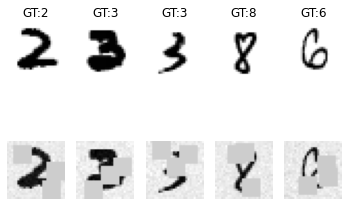

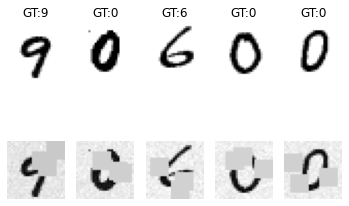

In [9]:
# visualize missing data pattern for training data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_train[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%i' %(y_train[indexes_train[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_train_obs[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

# visualize missing data pattern for test data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%i' %(y_test[indexes_test[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_test_obs[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

In [0]:
## For debugging: apply training to a subset of the datasets
Ntr = 2000
Ntt = 1000

x_train = x_train[indexes_train[0:Ntr],:,:]
y_train = y_train[indexes_train[0:Ntr]]
x_train_missing = x_train_missing[indexes_train[0:Ntr],:,:]
mask_train = mask_train[indexes_train[0:Ntr],:,:]

x_test  = x_test[indexes_test[0:Ntt],:,:]
y_test  = y_test[indexes_test[0:Ntt]]
x_test_missing = x_test_missing[indexes_test[0:Ntt],:,:]
mask_test = mask_test[indexes_test[0:Ntt],:,:]


# PCA Decomposition & AE artchitecture

In [0]:
DimAE      = 20#50

In [11]:
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2]))

.......... PCA Dim = 20
.... explained variance PCA (Tr) : 64.36%
.... explained variance PCA (Tt) : 65.11%


In [12]:
print('........ Define AE architecture')
flagAEType = 3
DimAE = 50

shapeData    = np.ones(3).astype(int)
shapeData[1:] =  x_train.shape[1:]

if flagAEType == 0: ## MLP-AE
  genSuffixModel = '_AEMLP%02d'%DimAE  

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[1]*shapeData[2],6*DimAE)
          self.fc2 = torch.nn.Linear(6*DimAE,2*DimAE)
          self.fc3 = torch.nn.Linear(2*DimAE,DimAE)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,10*DimAE)
          self.fc2 = torch.nn.Linear(10*DimAE,20*DimAE)
          self.fc3 = torch.nn.Linear(20*DimAE,shapeData[0]*shapeData[1]*shapeData[2])

      def forward(self, x):
          x = self.fc1( x )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x
elif flagAEType == 1: ## Conv model with no use of the central point
  dW = 5
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d(4)
          self.conv1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.conv2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,1,(4,4),stride=(4,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          self.convHR1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.convHR2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*DimAE,1,(1,1),padding=0,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )
          
          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )
          
          x   = torch.add(x,1.,xHR)
          
          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
    
elif flagAEType == 2: ## Conv model with no use of the central point
  dW = 5
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d(4)
          self.conv1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.conv2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,1,(4,4),stride=(4,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          self.convHR1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.convHR2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR4  = torch.nn.Conv2d(DimAE,1,(1,1),padding=0,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          xLR = self.pool1( xinp )
          x = self.conv1( xLR )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          dxLR = self.conv2Tr( x - xLR )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )
          
          dxHR = self.convHR1( xinp )
          dxHR = self.convHR2( F.relu(dxHR) )
          xHR  = torch.cat((self.convHR21(dxHR), self.convHR22(dxHR) * self.convHR23(dxHR)),dim=1)
          xHR  = self.convHR3( xHR )
          dxHR = self.convHR4( xHR - dxHR )
          
          x   = torch.cat((dxLR,dxHR),dim=1)
          #x   = torch.add(x,1.,xHR)
          
          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
elif flagAEType == 3: ## PCA
  genSuffixModel = '_AEPCA%02d'%(DimAE) 
  
  # train PCA
  pca           = decomposition.PCA(DimAE)
  pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
  pcs_ = pca.components_[0:DimAE,:]
    
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[1]*shapeData[2],DimAE,bias=False)
          self.fc1.weight = torch.nn.Parameter( torch.Tensor( pcs_ ))
          self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
          
      def forward(self, x):
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) - self.mean_ )
          return x
    
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,shapeData[0]*shapeData[1]*shapeData[2],bias=False)
          self.fc1.weight = torch.nn.Parameter( torch.Tensor( pcs_.transpose() ) )
          self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
      def forward(self, x):
          x = self.fc1( x ) + self.mean_
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print('AE Model type: '+genSuffixModel)
print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))


........ Define AE architecture
AE Model type: _AEPCA50
Model_AE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=50, bias=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=50, out_features=784, bias=False)
  )
)
Number of trainable parameters = 79968


torch.Size([21, 1, 28, 28])


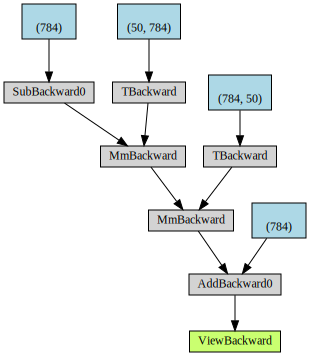

In [13]:
#Model visualisation
inputs = torch.randn(21,1,28,28)
y = model_AE(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

# Learning AE model

In [0]:
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model_AE  = model_AE.to(device)
#model_AE.resnet = model_AE.decoder.resnet.to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer        = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# mean-squared error loss
criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_var  = 0.0

            # Iterate over data.
            for inputs_ in dataloaders[phase]:
                inputs = inputs_[0]
                inputs = inputs.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #loss = criterion(outputs, inputs)
                    loss = torch.mean((outputs - inputs)**2)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss   += loss.item() * inputs.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss  = running_loss / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss = epoch_loss / var_Tr
            else:
              epoch_nloss = epoch_loss / var_Tt
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} NLoss: {:.4f} '.format(
                phase, epoch_loss, epoch_nloss))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# training AE model
model_AE = train_model(model_AE, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.7161 NLoss: 0.7161 
val Loss: 0.7102 NLoss: 0.6994 

Training complete in 0m 19s
Best val loss: 0.710230


# Evaluation of trained models

In [20]:
UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha4DVar      = np.array([0.1,1.])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent

NBGradCurrent   = 15
NBProjCurrent   = 0
batch_size      = 128

model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
#model           = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
        
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
              
flagLoadModel   = 0

# Classic Supervised Learning model using GENN models
fileAEModelInit = 'xxxx'

if flagLoadModel == 1:
  print('.... load model: '+fileAEModelInit)
  model.model_AE.load_state_dict(torch.load(fileAEModelInit))
  model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE_iter','_modelGrad_iter')))
  


.... Device GPU: False
Opitm type 2
4DVar model: Number of trainable parameters = 81076


In [0]:
batch_size = 64

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)


# training function for dinAE
# Each epoch has a training and validation phase
for phase in ['train', 'val']:        
    since = time.time()

    model.eval()
    #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    running_loss_Obs_GT  = 0.
    num_loss             = 0
    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))


        # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new,normgrad = model(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new,normgrad = model(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs,normgrad = model(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)

            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            loss_Obs_GT = torch.sum((targets_GT - inputs_missing)**2 * masks ) / torch.sum(masks)
            #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

            #loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #if phase == 'train':                                 
            #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #else:
            #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_Obs_GT      += loss_Obs_GT.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    epoch_loss_Obs_GT= running_loss_Obs_GT / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    #epoch_loss_All   = epoch_loss_All * stdTr**2
    #epoch_loss_I     = epoch_loss_I * stdTr**2
    #epoch_loss_R     = epoch_loss_R * stdTr**2
    #epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    #epoch_loss_Obs_GT= epoch_loss_Obs_GT * stdTr**2
    #epoch_loss_AE    = epoch_loss_AE * stdTr**2
    #epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE
    epoch_loss_4DVar_GT = alpha4DVar[0] * epoch_loss_Obs_GT + alpha4DVar[1] * epoch_loss_AE_GT

    print('{} Loss4DVar: {:.4e} Loss4DVarGT: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_4DVar_GT, epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))


In [0]:
## Visualisation
idxTr = np.random.permutation(y_train.shape[0])[0:10]
idxTt = np.random.permutation(y_test.shape[0])[0:10]
print(idxTt)

[2395  808 4396 7485 8807 8980 8506 2749 2286 7659]


Text(0.5, 1.0, 'Init 4.8775e-01')

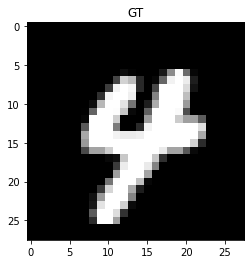

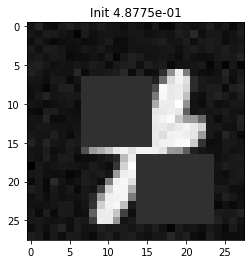

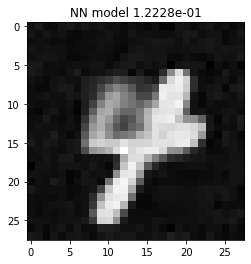

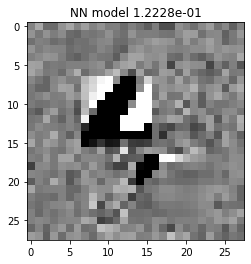

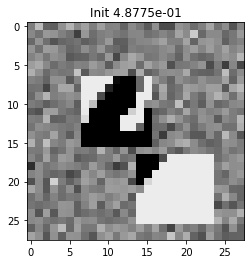

In [0]:
## Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]
#idxTt = np.random.permutation(y_test.shape[0])[0:10]
ii = 0

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,6)
plt.figure(5)
plt.imshow(y_test[idxTt[ii],:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze(),vmin=-0.5,vmax=0.5,cmap='gray')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,4)
plt.figure(3)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze(),vmin=-0.5,vmax=0.5,cmap='gray')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))



Text(0.5, 1.0, 'Init 6.3112e-01')

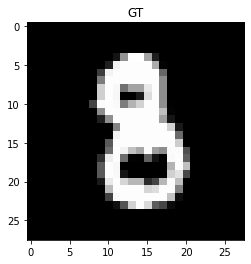

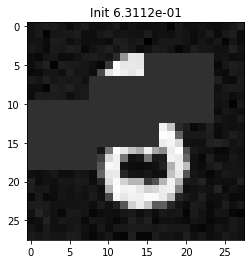

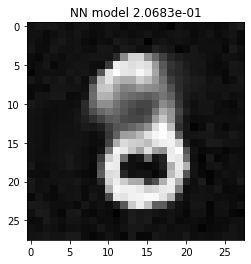

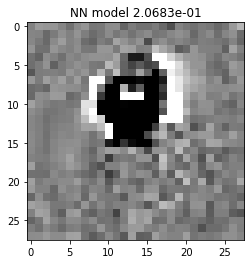

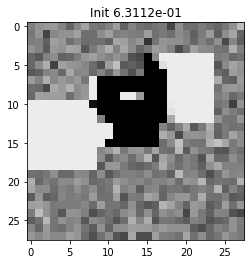

In [0]:
## Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]
#idxTt = np.random.permutation(y_test.shape[0])[0:10]
ii = 0

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,6)
plt.figure(5)
plt.imshow(y_test[idxTt[ii],:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze(),vmin=-0.5,vmax=0.5,cmap='gray')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,4)
plt.figure(3)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze(),vmin=-0.5,vmax=0.5,cmap='gray')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))



# Variational reconstruction using pre-trained prior and fixed-step gradient descent

In [0]:
# Variational assimilation reconstruction
# for test data indices idxTt
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('... alphaObs %.3f'%model.model_Grad.compute_Grad.alphaObs.item())    
print('... alphaPrior %.3f'%model.model_Grad.compute_Grad.alphaAE.item())    
print('... AEType %d'%flagAEType)

# model creation
batch_size      = len(idxTt)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations
NiterGrad       = 20 # Number of gradient descent step

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01
StepLoss   = 50
NIter      = 800#650#1601#5000#
delta      = 5e1
ii = 0
idxTtOneBatch = idxTt[ii:ii+1]

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = model(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = model(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = model(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Fixed-step gradient-based descent of the variational cost')

    # AE projection
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIter):
        # AE projection
        x_pred = model.model_AE( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks)) / torch.sum( 1.-masks)

        # overall loss
        loss = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                                                          
        # evaluate and store losses
        if( np.mod(kk,StepLoss) == 0 ):  

            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
            compt_kk = compt_kk + 1
loss4DVar     = losses_test
y_pred_VarMin = xhat.detach().cpu().numpy()
if flagAEType == 1 :
  loss4DVarGENN = losses_test
  y_pred_VarMinGENN = xhat.detach().cpu().numpy()
elif flagAEType == 3 :                
  #loss4DVarPCA = losses_test
  y_pred_VarMinPCA = xhat.detach().cpu().numpy()


... alphaObs 1.495
... alphaPrior 0.599
... AEType 3
.....
..... alpha : obs 1.495 --- dyn 0.599
torch.Size([1, 28, 28])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 7.837442e-02   ---  dyn 6.055589e-02   ---  obs 4.386215e-03
.....
.....
..... Fixed-step gradient-based descent of the variational cost
..... Loss Grad Descent 0:  4DVar 8.213497e-02   ---  GT 4.877520e-01   ---  Interp GT 2.199576e+00   ---  dyn 1.371184e-01   ---  obs 0.000000e+00
..... Loss Grad Descent 50:  4DVar 3.179388e-02   ---  GT 3.607560e-01   ---  Interp GT 1.614329e+00   ---  dyn 4.059115e-02   ---  obs 5.001601e-03
..... Loss Grad Descent 100:  4DVar 2.904362e-02   ---  GT 3.435305e-01   ---  Interp GT 1.536430e+00   ---  dyn 3.696043e-02   ---  obs 4.616809e-03
..... Loss Grad Descent 150:  4DVar 2.817949e-02   ---  GT 3.362163e-01   ---  Interp GT 1.503205e+00   ---  dyn 3.584029e-02   ---  obs 4.487642e-03
..... Loss Grad Descent 200:  4DVar 2.772325e-02   ---  

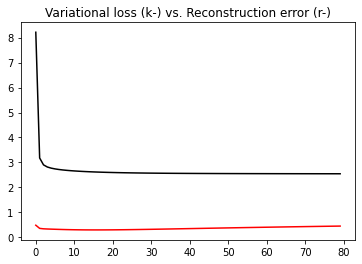

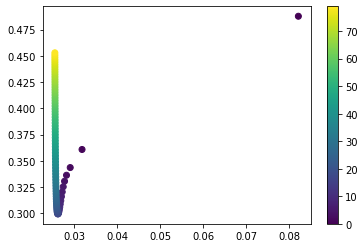

In [0]:
plt.figure(1)
plt.plot(100*loss4DVar[:,0],'k-')
plt.plot(loss4DVar[:,1],'r-')
plt.title('Variational loss (k-) vs. Reconstruction error (r-)')

plt.figure(2)
plt.scatter(loss4DVar[:,0], loss4DVar[:,1], c=np.arange(loss4DVar.shape[0]))
plt.colorbar()


In [0]:
# Variational assimilation reconstruction for test data indices idxTt
# minimisation in the latent space
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model creation
batch_size      = len(idxTt)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations
NiterGrad       = 20 # Number of gradient descent step

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01
StepLoss   = 50
NIter      = 10001
alpha4DVar = 1e0* np.array([.1,1.])
delta      = 1e2

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTt,:,:]),torch.Tensor(x_test_obs[idxTt,:,:]),torch.Tensor(mask_test[idxTt,:,:]),torch.Tensor(x_test[idxTt,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = model(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = model(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = model(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Fixed-step gradient-based descent of the variational cost')
    # AE projection
    xhat = torch.Tensor(np.random.randn(x_init.size(0),DimAE)).to(device) 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIter):
        # AE projection
        x_pred = model.model_AE.decoder( xhat )
        # dynamical loss
        #loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((x_pred - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((x_pred - x_GT)**2)
        loss_IGT = torch.sum((x_pred - x_GT)**2 * (1.-masks)) / torch.sum( 1.-masks)

        # overall loss
        loss = alpha4DVar[0] * loss_obs #+ alpha4DVar[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                                                          
        # evaluate and store losses
        if( np.mod(kk,StepLoss) == 0 ):  

            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
            compt_kk = compt_kk + 1

loss4DVar = losses_test
y_pred_VarMin = xhat
                

.....
..... alpha : obs 0.100 --- dyn 1.000
torch.Size([2, 28, 28])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 2.809244e-01   ---  dyn 6.272548e-02   ---  obs 4.118789e-03
.....
.....
..... Fixed-step gradient-based descent of the variational cost
..... Loss Grad Descent 0:  4DVar 5.855781e-02   ---  GT 9.296631e-01   ---  Interp GT 1.832277e+00   ---  dyn 7.978333e-04   ---  obs 5.855781e-01
..... Loss Grad Descent 50:  4DVar 2.112465e-02   ---  GT 6.069341e-01   ---  Interp GT 1.644014e+00   ---  dyn 7.978333e-04   ---  obs 2.112465e-01
..... Loss Grad Descent 100:  4DVar 1.317280e-02   ---  GT 5.239171e-01   ---  Interp GT 1.553200e+00   ---  dyn 7.978333e-04   ---  obs 1.317280e-01
..... Loss Grad Descent 150:  4DVar 1.102135e-02   ---  GT 4.946715e-01   ---  Interp GT 1.504742e+00   ---  dyn 7.978333e-04   ---  obs 1.102135e-01
..... Loss Grad Descent 200:  4DVar 1.020157e-02   ---  GT 4.808957e-01   ---  Interp GT 1.476958e+00   ---  

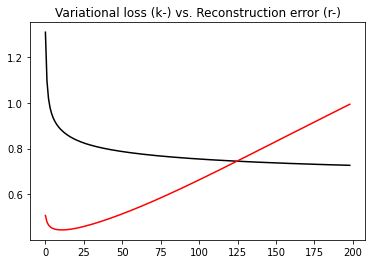

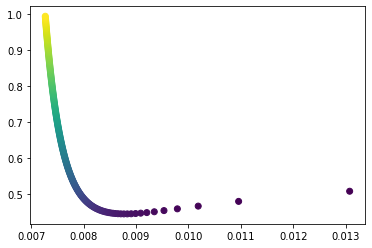

In [0]:
plt.figure(1)
plt.plot(100*loss4DVar[2:,0],'k-')
plt.plot(loss4DVar[2:,1],'r-')
plt.title('Variational loss (k-) vs. Reconstruction error (r-)')

plt.figure(2)
plt.scatter(loss4DVar[2:,0], loss4DVar[2:,1], c=np.arange(loss4DVar.shape[0]-2))

In [0]:
# Sequential version of tre trained solver
# for idxTt samples
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model creation
batch_size      = len(idxTt)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01
NIter  = 10

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = model(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = model(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = model(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Sequential applicaton of the trained model')
    # AE projection
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    grad     = model.model_Grad.compute_Grad(xhat, model.model_AE(xhat),x_obs,masks)
    normgrad = torch.sqrt( torch.mean( grad**2 ) )
                    
    losses_test = []
    compt_kk    = 0
    for kk in range(0,NIter+1):
        if kk > 0 :
          # AE projection
          x_pred = model.model_AE( xhat )
          
          # Compute Gradient-based update
          if model.OptimType == 0:
              grad  = model.model_Grad( xhat, x_pred, x_obs, masks, normgrad)
          elif model.OptimType == 1:
              if kk == 1:
                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, None, normgrad)
              else:
                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, grad_old, normgrad)
              grad_old = 1. * grad
          elif model.OptimType == 2:
              if kk == 1:
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, None,None, normgrad)
              else:
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, hidden, cell, normgrad)            
          xhat = xhat - grad
                         
        # losses
        loss_dyn = torch.mean((xhat - model.model_AE( xhat ))**2)
        #loss_dyn = torch.sum((xhat - model.model_AE( xhat ))**2  , dim = -1)
        #loss_dyn = torch.sum( loss_dyn  , dim = -1)

        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
        #loss_obs = torch.sum((xhat - x_obs)**2 * masks , dim = -1)
        #loss_obs = torch.sum( loss_obs  , dim = -1)

        lossVar = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
        loss_GT = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks) ) / torch.sum(1. - masks)

        # store as np
        if( compt_kk == 0 ):
            losses_test = torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
        else:
            losses_test = np.concatenate( (losses_test,torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
        print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk+1,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
        compt_kk = compt_kk + 1

loss4_LSTMDescent = losses_test
y_pred_LSTMDescent = xhat.detach().cpu().numpy()

if flagAEType == 1 :
  loss_LSTMDescentGENN = losses_test
  y_pred_LSTMDescentGENN = xhat.detach().cpu().numpy()
elif flagAEType == 3 :                
  loss_LSTMDescentPCA = losses_test
  y_pred_LSTMDescentPCA = xhat.detach().cpu().numpy()


.....
..... alpha : obs 1.495 --- dyn 0.599
torch.Size([1, 28, 28])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 7.837442e-02   ---  dyn 6.055589e-02   ---  obs 4.386215e-03
.....
.....
..... Sequential applicaton of the trained model
..... Loss Grad Descent 1:  4DVar 8.213497e-02   ---  GT 4.877520e-01   ---  Interp GT 2.199576e+00   ---  dyn 1.371184e-01   ---  obs 0.000000e+00
..... Loss Grad Descent 2:  4DVar 7.415853e-02   ---  GT 4.670909e-01   ---  Interp GT 2.100352e+00   ---  dyn 1.186882e-01   ---  obs 2.048545e-03
..... Loss Grad Descent 3:  4DVar 6.800979e-02   ---  GT 4.373285e-01   ---  Interp GT 1.968475e+00   ---  dyn 1.082737e-01   ---  obs 2.108470e-03
..... Loss Grad Descent 4:  4DVar 6.198265e-02   ---  GT 4.116344e-01   ---  Interp GT 1.845991e+00   ---  dyn 9.451416e-02   ---  obs 3.589601e-03
..... Loss Grad Descent 5:  4DVar 5.861808e-02   ---  GT 3.775726e-01   ---  Interp GT 1.690240e+00   ---  dyn 8.679900e-02   ---

In [0]:
flagAEType

1

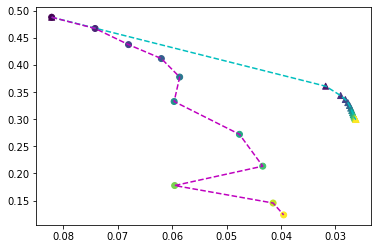

In [0]:
LVarDescent = loss4DVar.shape[0]
LLSTMDescent = loss4_LSTMDescent.shape[0]
#plt.figure(1)
#plt.plot(np.arange(LVarDescent),100*loss4DVar[:,0],'k-')
#plt.plot(np.arange(LVarDescent),loss4DVar[:,1],'r-')
#plt.plot(np.arange(LLSTMDescent)/LLSTMDescent*LVarDescent,100*loss4_LSTMDescent[:,0],'k--')
#plt.plot(np.arange(LLSTMDescent)/LLSTMDescent*LVarDescent,loss4_LSTMDescent[:,1],'r--')
#plt.title('Variational loss (k-) vs. Reconstruction error (r-)')

plt.figure(2)
plt.plot(loss4DVar[:,0], loss4DVar[:,1],'c--')
plt.scatter(loss4DVar[:,0], loss4DVar[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss4_LSTMDescent[:,0], loss4_LSTMDescent[:,1],'m--')
sca = plt.scatter(loss4_LSTMDescent[:,0], loss4_LSTMDescent[:,1], c=np.arange(LLSTMDescent),marker='o')
#plt.xscale('log')
sca.axes.invert_xaxis()


#plt.figure(3)
#plt.plot(loss4DVar[:,1], loss4DVar[:,0],'m-o')
#plt.scatter(loss4DVar[:,1], loss4DVar[:,0], c=np.arange(LVarDescent),marker='^')
#sca = plt.scatter(loss4_LSTMDescent[:,1], loss4_LSTMDescent[:,0], c=np.arange(LLSTMDescent),marker='o')
#sca.axes.invert_xaxis()




Text(0.5, 1.0, 'PCA')

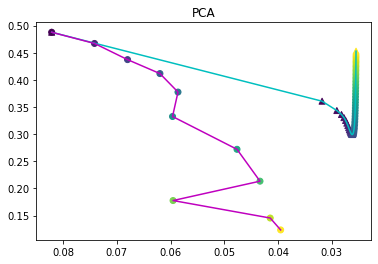

In [0]:
LVarDescent = loss4DVarPCA.shape[0]
LLSTMDescent = loss_LSTMDescentPCA.shape[0]

plt.figure(2)
plt.plot(loss4DVarPCA[:,0], loss4DVarPCA[:,1],'c-')
plt.scatter(loss4DVarPCA[:,0], loss4DVarPCA[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1],'m-')
sca = plt.scatter(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1], c=np.arange(LLSTMDescent),marker='o')
#plt.yscale('log')
sca.axes.invert_xaxis()
plt.title('PCA')

Text(0.5, 1.0, 'GENN')

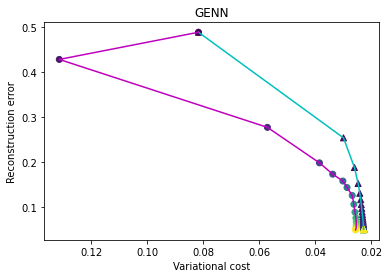

In [0]:
LVarDescent = loss4DVarGENN.shape[0]
LLSTMDescent = loss_LSTMDescentGENN.shape[0]

plt.figure(2)
plt.plot(loss4DVarGENN[:,0], loss4DVarGENN[:,1],'c-')
plt.scatter(loss4DVarGENN[:,0], loss4DVarGENN[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1],'m-')
sca = plt.scatter(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1], c=np.arange(LLSTMDescent),marker='o')
#plt.yscale('log')
sca.axes.invert_xaxis()
plt.xlabel('Variational cost')
plt.ylabel('Reconstruction error')
plt.title('GENN')

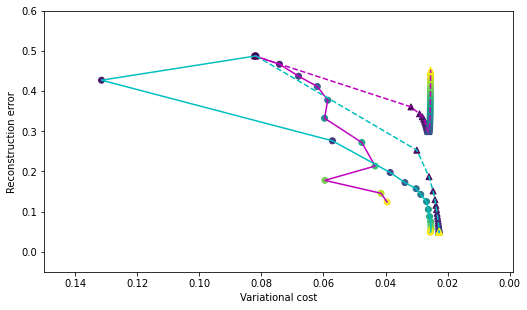

In [0]:

plt.figure(2,figsize=[8.4, 4.8])

LVarDescent = loss4DVarPCA.shape[0]
LLSTMDescent = loss_LSTMDescentPCA.shape[0]
plt.plot(loss4DVarPCA[:,0], loss4DVarPCA[:,1],'m--')
plt.scatter(loss4DVarPCA[:,0], loss4DVarPCA[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1],'m-', label='')
sca = plt.scatter(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1], c=np.arange(LLSTMDescent),marker='o')

LVarDescent = loss4DVarGENN.shape[0]
LLSTMDescent = loss_LSTMDescentGENN.shape[0]
plt.plot(loss4DVarGENN[:,0], loss4DVarGENN[:,1],'c--')
plt.scatter(loss4DVarGENN[:,0], loss4DVarGENN[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1],'c-', label='')
sca = plt.scatter(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1], c=np.arange(LLSTMDescent),marker='o')

#plt.yscale('log')
plt.xlabel('Variational cost')
plt.ylabel('Reconstruction error')
plt.ylim([-0.05,0.6])
plt.xlim([-0.001,0.15])
sca.axes.invert_xaxis()
#plt.legend()

plt.savefig("fig_DescentConvergenceMNIST.pdf")
plt.savefig("fig_DescentConvergenceMNIST.png")

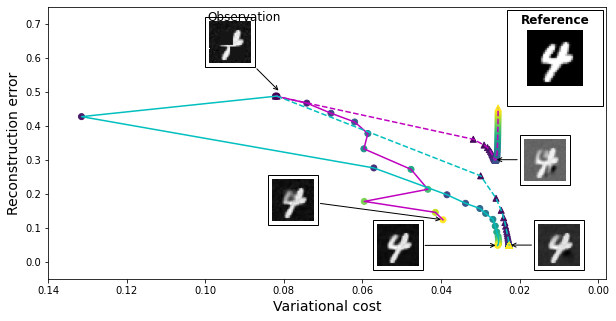

In [0]:
Vmin = (0-meanTr)/stdTr
Vmax = (255-meanTr)/stdTr

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox, AnchoredText
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
grayCMAP = plt.get_cmap('gray', 256)

fig, ax = plt.subplots(figsize=[10., 5])

LVarDescent = loss4DVarPCA.shape[0]
LLSTMDescent = loss_LSTMDescentPCA.shape[0]
plt.plot(loss4DVarPCA[:,0], loss4DVarPCA[:,1],'m--')
plt.scatter(loss4DVarPCA[:,0], loss4DVarPCA[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1],'m-', label='')
sca = plt.scatter(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1], c=np.arange(LLSTMDescent),marker='o')

LVarDescent = loss4DVarGENN.shape[0]
LLSTMDescent = loss_LSTMDescentGENN.shape[0]
plt.plot(loss4DVarGENN[:,0], loss4DVarGENN[:,1],'c--')
plt.scatter(loss4DVarGENN[:,0], loss4DVarGENN[:,1], c=np.arange(LVarDescent),marker='^')
plt.plot(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1],'c-', label='')
sca = plt.scatter(loss_LSTMDescentGENN[:,0], loss_LSTMDescentGENN[:,1], c=np.arange(LLSTMDescent),marker='o')

#plt.yscale('log')
plt.xlabel('Variational cost',fontsize=14)
plt.ylabel('Reconstruction error',fontsize=14)
plt.ylim([-0.05,0.75])
plt.xlim([-0.002,0.14])
sca.axes.invert_xaxis()

newcolors = grayCMAP(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[0:10, :] = pink
newcmp = ListedColormap(newcolors)

imvisu = x_test_obs[idxTt[ii],:,:].squeeze()
imvisu[ np.where( imvisu == 0.0) ] = Vmin-0.1
imvisu = (imvisu - Vmin) / (Vmax-Vmin)

imagebox = OffsetImage(x_test_obs[idxTt[ii],:,:].squeeze(), zoom=1.5,cmap=newcmp)
ab = AnnotationBbox(imagebox, (0.081,0.5),
                    xybox=(-50, 50),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

imvisu = y_pred_VarMinPCA[0,:,:].squeeze()
imvisu = (imvisu - Vmin) / (Vmax-Vmin)
#immin = np.min(imvisu)
#immax = np.max(imvisu)
#imvisu = (y_pred_VarMinPCA[0,:,:].squeeze() - immin) / (immax-immin)

#newcolors = grayCMAP(np.linspace(np.min(imvisu), np.max(imvisu), int(256*(np.max(imvisu)-np.min(imvisu))/(Vmax-Vmin))))
newcolors = grayCMAP(np.linspace(0, 1, 256))
newcmp = ListedColormap(newcolors)

imagebox = OffsetImage(imvisu, zoom=1.5,cmap=newcmp)
ab = AnnotationBbox(imagebox, (loss4DVarPCA[13,0], loss4DVarPCA[13,1]),
                    xybox=(50,0),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

imvisu = y_pred_LSTMDescentPCA[0,:,:].squeeze()
imvisu = (imvisu - Vmin) / (Vmax-Vmin)
imagebox = OffsetImage(imvisu, zoom=1.5,cmap=newcmp)
ab = AnnotationBbox(imagebox, (loss_LSTMDescentPCA[10,0], loss_LSTMDescentPCA[10,1]),
                    xybox=(-150,20),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

imvisu = y_pred_LSTMDescentGENN[0,:,:].squeeze()
imvisu = (imvisu - Vmin) / (Vmax-Vmin)
imagebox = OffsetImage(imvisu, zoom=1.5,cmap=newcmp)
ab = AnnotationBbox(imagebox, (loss_LSTMDescentGENN[15,0], loss_LSTMDescentGENN[15,1]),
                    xybox=(-100,0),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

imvisu = y_pred_VarMinGENN[0,:,:].squeeze()
imvisu = (imvisu - Vmin) / (Vmax-Vmin)
imagebox = OffsetImage(imvisu, zoom=1.5,cmap=newcmp)
ab = AnnotationBbox(imagebox, (loss4DVarGENN[-1,0], loss4DVarGENN[-1,1]),
                    xybox=(50,0),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)

imvisu = x_test[idxTt[ii],:,:].squeeze()
imvisu = (imvisu - Vmin) / (Vmax-Vmin)
imagebox = OffsetImage(imvisu, zoom=2,cmap=newcmp)
ab = AnnotationBbox(imagebox, (0.011,0.6),frameon=True,pad=2.)
ax.add_artist(ab)

#ax.text(0.011,.7, 'Reference', style='italic')

offsetbox = TextArea("Reference", minimumdescent=False, 
                     textprops=dict(fontsize=12,fontweight ='bold'))
ab = AnnotationBbox(offsetbox, (0.011,0.71),frameon=False)#,
                    #fontsize=1)#,
                    #xybox=(0.0,0.),
                    #xycoords='data',
                    #boxcoords=("axes fraction", "data"),
                    #box_alignment=(0., 0.5),
                    #arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab)


offsetbox = TextArea("Observation", minimumdescent=False, 
                     textprops=dict(fontsize=12,fontstyle ='normal'))

ab = AnnotationBbox(offsetbox, (0.09,0.72),frameon=False)#,
ax.add_artist(ab)


In [0]:
imvisu = x_test_obs[idxTt[ii],:,:].squeeze()
imvisu

array([[-0.42870699, -0.18779166, -0.53152917, -0.55253083, -0.35396452,
        -0.22309488, -0.38120665, -0.29341025, -0.42962744, -0.30161904,
        -0.41161664, -0.40247027, -0.53612357, -0.38123852, -0.45309477,
        -0.56569627, -0.363273  , -0.62424153, -0.62453822, -0.34644532,
        -0.3853832 , -0.49923248, -0.42319655, -0.27780574, -0.47009205,
        -0.36996334, -0.59583783, -0.39904492],
       [-0.38937676, -0.47132533, -0.32837729, -0.34204579, -0.42122215,
        -0.47607684, -0.67574761, -0.33128969, -0.49268783, -0.42497204,
        -0.40099863, -0.44051862, -0.47226102, -0.39796827, -0.39470062,
        -0.48606652, -0.45680473, -0.4038977 , -0.45419676, -0.28532749,
        -0.37748052, -0.12908086, -0.51274732, -0.38352762, -0.38311373,
        -0.51612176, -0.45743185, -0.32370478],
       [-0.50946669, -0.34268721, -0.48923183, -0.59682666, -0.52301674,
        -0.49949525, -0.47096492, -0.55226844, -0.50968974, -0.43273184,
        -0.3256122 , -0.5604

...... Reconstruction error 
.. Initialisation: 1.4452e+00
.. VarMin Solver : 2.9934e-01
.. LSTM Solver   : 1.2367e-01


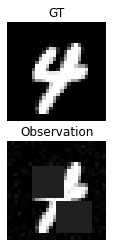

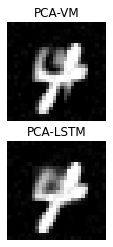

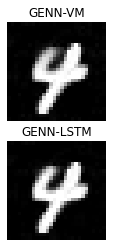

In [0]:
Vmin = (0-meanTr)/stdTr
Vmax = (255-meanTr)/stdTr
plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.axis('off')
plt.title('GT')

plt.subplot(2,1,2)
#plt.figure(2)
plt.imshow(x_test_obs[idxTt[ii],:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('Observation')
plt.savefig("fig_MNIST%04d_GTObs.png"%idxTt[ii])

plt.figure(2)
plt.subplot(2,1,1)
#plt.figure(4)
plt.imshow(y_pred_VarMinPCA[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('PCA-VM')

plt.subplot(2,1,2)
#plt.figure(5)
plt.imshow(y_pred_LSTMDescentPCA[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('PCA-LSTM')
plt.savefig("fig_MNIST%04d_PCA.png"%idxTt[ii])

plt.figure(3)
plt.subplot(2,1,1)
#plt.figure(4)
plt.imshow(y_pred_VarMinGENN[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('GENN-VM')

plt.subplot(2,1,2)
#plt.figure(5)
plt.imshow(y_pred_LSTMDescentGENN[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('GENN-LSTM')
plt.savefig("fig_MNIST%04d_GENN.png"%idxTt[ii])

print('...... Reconstruction error ')
print('.. Initialisation: %.4e'%np.mean( (x_test_Init[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
print('.. VarMin Solver : %.4e'%np.mean( (y_pred_VarMin[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
print('.. LSTM Solver   : %.4e'%np.mean( (y_pred_LSTMDescent[0,:,:]-x_test[idxTt[ii],:,:])**2 ))


In [0]:
Vmin = (0-meanTr)/stdTr
Vmax = (255-meanTr)/stdTr
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(x_test[idxTt[0],:,:].squeeze(),cmap='gray')
plt.axis('off')
plt.title('GT')

plt.subplot(1,2,2)
#plt.figure(2)
plt.imshow(x_test_obs[idxTt[0],:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('Observation')

plt.figure(2)
plt.subplot(1,2,1)
#plt.figure(4)
plt.imshow(y_pred_VarMin[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('PCA-VarMin')

plt.subplot(1,2,2)
#plt.figure(5)
plt.imshow(y_pred_LSTMDescent[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('PCA-AD-LSTM')

print('...... Reconstruction error ')
print('.. Initialisation: %.4e'%np.mean( (x_test_Init[0,:,:]-x_test[idxTt[0],:,:])**2 ))
print('.. VarMin Solver : %.4e'%np.mean( (y_pred_VarMin[0,:,:]-x_test[idxTt[0],:,:])**2 ))
print('.. LSTM Solver   : %.4e'%np.mean( (y_pred_LSTMDescent[0,:,:]-x_test[idxTt[0],:,:])**2 ))


In [0]:
( np.max(x_train) * stdTr + meanTr ) 

255.0